In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

#### 第一步：数据获取
The city of Berkeley maintains an [Open Data Portal](https://data.cityofberkeley.info/) for citizens to access data about the city.  We will be examining [Call Data](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5).

<img src="data/calls_desc.png" width=800px />

将数据抓取功能封装到`ds100_utils.py`

In [2]:
import ds100_utils

calls_url = 'https://data.cityofberkeley.info/api/views/k2nh-s5h5/rows.csv?accessType=DOWNLOAD'
calls_file = ds100_utils.fetch_and_cache(calls_url, 'calls.csv')
calls = pd.read_csv(calls_file, warn_bad_lines=True)
calls.head()

Using cached version that was downloaded (UTC): Sun Mar 20 22:36:45 2022


,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Council Districts_uniq_prepend,Council Districts_from_hg3u_n7v4,Council Districts_from_c8zs_8y7x,Zip Codes,Police Beats,Census Tracts,Council Districts
0,18092358,THEFT MISD. (UNDER $950),12/19/2018 12:00:00 AM,09:30,LARCENY,3,06/18/2019 10:28:09 AM,"2000 FOURTH ST\nBerkeley, CA\n(37.867613, -122...",2000 FOURTH ST,Berkeley,CA,7.0,1716.0,7.0,1502.0,6.0,11.0,5.0
1,19000172,BURGLARY RESIDENTIAL,12/19/2018 12:00:00 AM,00:01,BURGLARY - RESIDENTIAL,3,06/18/2019 10:28:09 AM,"1200 EVELYN AVE\nBerkeley, CA\n(37.883153, -12...",1200 EVELYN AVE,Berkeley,CA,NaN,NaN,NaN,1498.0,NaN,NaN,NaN
2,18069978,BURGLARY AUTO,12/19/2018 12:00:00 AM,08:07,BURGLARY - VEHICLE,3,06/18/2019 10:28:09 AM,"2900 SAN PABLO AVE\nBerkeley, CA\n(37.853576, ...",2900 SAN PABLO AVE,Berkeley,CA,8.0,933.0,8.0,1494.0,5.0,16.0,8.0
3,18070016,THEFT MISD. (UNDER $950),12/19/2018 12:00:00 AM,00:00,LARCENY,3,06/18/2019 10:28:09 AM,"GRAYSON STREET & 7TH ST\nBerkeley, CA\n(37.855...",GRAYSON STREET & 7TH ST,Berkeley,CA,8.0,10.0,8.0,1502.0,5.0,11.0,8.0
4,18070047,THEFT MISD. (UNDER $950),12/19/2018 12:00:00 AM,16:08,LARCENY,3,06/18/2019 10:28:09 AM,"2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...",2200 SHATTUCK AVE,Berkeley,CA,1.0,613.0,1.0,1496.0,11.0,32.0,1.0


In [3]:
len(calls)

4433

In [4]:
print(calls['Block_Location'].iloc[0])

2000 FOURTH ST
Berkeley, CA
(37.867613, -122.299898)


#### 针对数据进行简单观察

1. `EVENTDT` -- Contains the incorrect time
1. `EVENTTM` -- Contains the time in 24 hour format (What timezone?)
1. `CVDOW` -- Encodes the day of the week (see data documentation).
1. `InDbDate` -- Appears to be correctly formatted and appears pretty consistent in time.
1. **`Block_Location` -- a multi-line string that contains coordinates.**
1. `BLKADDR` -- Appears to be the address in `Block Location`.
1. `City` and `State` seem redundant given this is supposed to be the city of Berkeley dataset.

#### 问题1：抽取地点信息
地点信息包括经纬度，如何进行抽取？
* 观察数据，发现哪些属性可以提取经纬度
* 创建新的DataFrame`calls_lat_lon`，包含两个新列`Lat`和`Lon`

In [5]:
# 查看第一个`Block_Location`信息


'2000 FOURTH ST\nBerkeley, CA\n(37.867613, -122.299898)'

In [6]:
# 创建新的DataFrame变量`calls_lat_lon`，包含两个新列Lat和Lon
calls_lat_lon.head(10)

,Lat,Lon
0,37.867613,-122.299898
1,37.883153,-122.292104
2,37.853576,-122.287202
3,37.855294,-122.292475
4,37.869363,-122.268028
5,37.870054,-122.284263
6,37.869105,-122.270064
7,37.888199,-122.250826
8,37.871828,-122.270516
9,37.880667,-122.29489


#### 问题2：合并经纬度信息
如何将已经抽取出的经纬度信息，合并到DataFrame变量`calls`中？

In [7]:
# 观察数据，经纬度缺失的数据有哪些？


Lat    158
Lon    158
dtype: int64

In [8]:
# 输出经纬度缺失的数据项的`Block_Location`属性（只需打印出前10个）


20                       900 NORTHGATE AVE\nBerkeley, CA
103                    1600 SIXTY-THIRD ST\nBerkeley, CA
104               STANFORD AV & VALLEJO ST\nBerkeley, CA
151                        900 PARKSIDE DR\nBerkeley, CA
158    MARTIN LUTHER KING JR WAY &GRANT ST\nBerkeley, CA
187        CAMELIA STREET &RAILROAD TRACKS\nBerkeley, CA
196                 DOCK N &UNIVERSITY AVE\nBerkeley, CA
203                         1625 TRUMAN ST\nBerkeley, CA
207                         2100 VALLEY ST\nBerkeley, CA
336                        800 SHATTUCK SQ\nBerkeley, CA
Name: Block_Location, dtype: object

In [9]:
# 将经纬度信息合并到DataFrame变量`calls`中


,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,Council Districts_uniq_prepend,Council Districts_from_hg3u_n7v4,Council Districts_from_c8zs_8y7x,Zip Codes,Police Beats,Census Tracts,Council Districts,Lat,Lon
0,18092358,THEFT MISD. (UNDER $950),12/19/2018 12:00:00 AM,09:30,LARCENY,3,06/18/2019 10:28:09 AM,"2000 FOURTH ST\nBerkeley, CA\n(37.867613, -122...",2000 FOURTH ST,Berkeley,CA,7.0,1716.0,7.0,1502.0,6.0,11.0,5.0,37.867613,-122.299898
1,19000172,BURGLARY RESIDENTIAL,12/19/2018 12:00:00 AM,00:01,BURGLARY - RESIDENTIAL,3,06/18/2019 10:28:09 AM,"1200 EVELYN AVE\nBerkeley, CA\n(37.883153, -12...",1200 EVELYN AVE,Berkeley,CA,NaN,NaN,NaN,1498.0,NaN,NaN,NaN,37.883153,-122.292104
2,18069978,BURGLARY AUTO,12/19/2018 12:00:00 AM,08:07,BURGLARY - VEHICLE,3,06/18/2019 10:28:09 AM,"2900 SAN PABLO AVE\nBerkeley, CA\n(37.853576, ...",2900 SAN PABLO AVE,Berkeley,CA,8.0,933.0,8.0,1494.0,5.0,16.0,8.0,37.853576,-122.287202
3,18070016,THEFT MISD. (UNDER $950),12/19/2018 12:00:00 AM,00:00,LARCENY,3,06/18/2019 10:28:09 AM,"GRAYSON STREET & 7TH ST\nBerkeley, CA\n(37.855...",GRAYSON STREET & 7TH ST,Berkeley,CA,8.0,10.0,8.0,1502.0,5.0,11.0,8.0,37.855294,-122.292475
4,18070047,THEFT MISD. (UNDER $950),12/19/2018 12:00:00 AM,16:08,LARCENY,3,06/18/2019 10:28:09 AM,"2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...",2200 SHATTUCK AVE,Berkeley,CA,1.0,613.0,1.0,1496.0,11.0,32.0,1.0,37.869363,-122.268028


#### 问题3：对地点信息做探索式数据分析

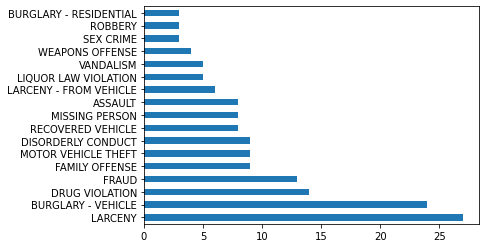

In [10]:
# 输出经纬度缺失数据记录的`CVLEGEND`属性的分布图


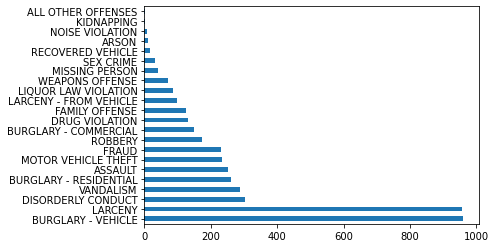

In [11]:
# 输出所有数据记录的`CVLEGEND`属性的分布图


#### 观察上面两幅图，给出你的结论
* 结论1
* 结论2

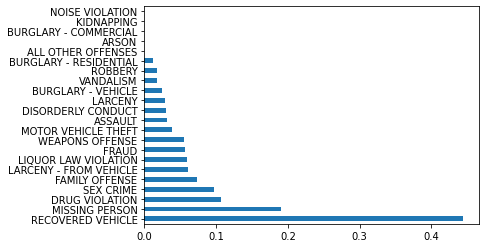

In [12]:
# 输出不同`CVLEGEND`的缺失数据比


#### 第4步：绘制犯罪地图

In [13]:
import folium
import folium.plugins

# 使用folium工具，将经纬度不为空的数据绘制在地图上
